# **SIGNIFY - BELAJAR BAHASA ISYARAT**

# **Import Library**

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Download & Extract Dataset**

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
# Upload file tanpa menampilkan hasil output upload
_ = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Download kaggle dataset and unzip the file
import os
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan dan atur permission file kaggle.json
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d alvinbintang/sibi-dataset

Dataset URL: https://www.kaggle.com/datasets/alvinbintang/sibi-dataset
License(s): copyright-authors


In [ ]:
# Unzip dataset
!unzip -q sibi-dataset.zip

# **Exploratory Data Analysis**

## **Load Dataset**

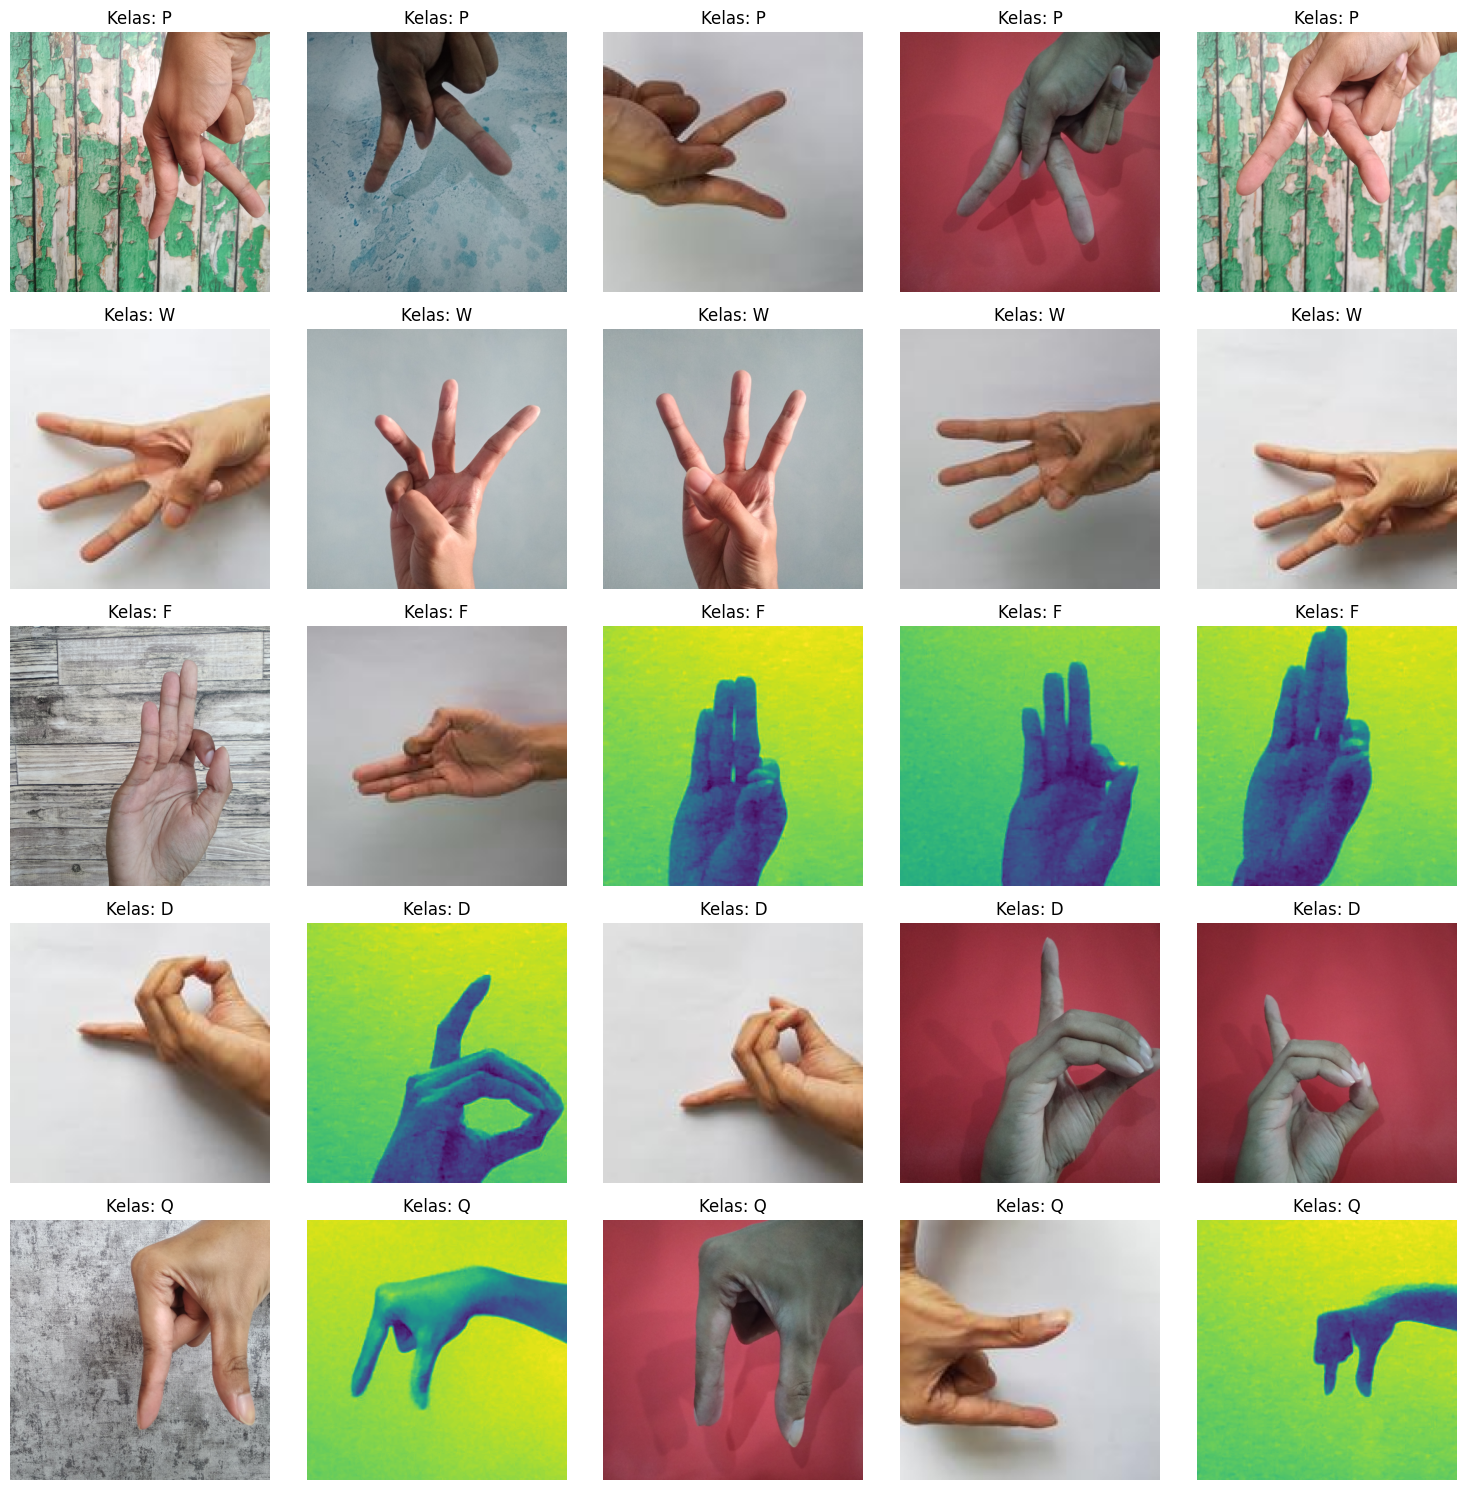

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Membuat kamus yang menyimpan nama file gambar untuk setiap kelas
sibi_images = {}

# Path dataset Anda
dataset_path = "SIBI"

# Kumpulkan nama file gambar per kelas
for label in sorted(os.listdir(dataset_path)):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
        image_files = [f for f in os.listdir(label_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        sibi_images[label] = image_files

# Plot gambar secara acak dari beberapa kelas
sample_labels = np.random.choice(sorted(sibi_images.keys()), 5, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5 kelas, 5 gambar

for i, label in enumerate(sample_labels):
    images = np.random.choice(sibi_images[label], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, label, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"Kelas: {label}")
        axs[i, j].axis('off')

fig.tight_layout()
plt.show()

## **Data Visualization**

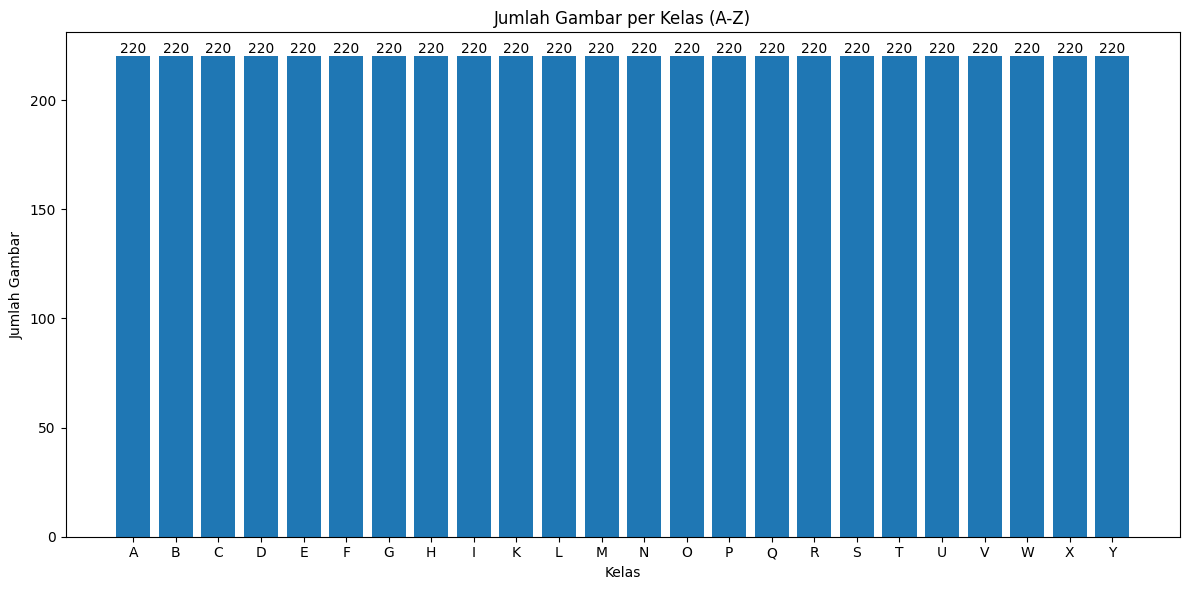

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Path ke dataset
dataset_path = "SIBI"

# Hitung jumlah gambar per kelas
label_counts = {}
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        count = len([file for file in os.listdir(label_path) if file.lower().endswith(('.jpg', '.png', '.jpeg'))])
        label_counts[label] = count

# Urutkan label berdasarkan abjad
sorted_labels = sorted(label_counts.keys())
sorted_counts = [label_counts[label] for label in sorted_labels]

# Visualisasi
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_labels, sorted_counts)
plt.title("Jumlah Gambar per Kelas (A-Z)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")

# Tambahkan label angka di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image

corrupt_images = []

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verifikasi gambar
        except Exception as e:
            corrupt_images.append(img_path)

print(f"Jumlah gambar korup: {len(corrupt_images)}")
if corrupt_images:
    print("Contoh gambar korup:", corrupt_images[:5])

Jumlah gambar korup: 0


# **Data Preprocessing**

## **Data Splitting**

In [ ]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

# Path asal data setelah augmentasi
source_dir = Path("SIBI")
# Path tujuan split
target_dir = Path("Signify_Cleaned")

# Rasio split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Pastikan folder target bersih
if target_dir.exists():
    shutil.rmtree(target_dir)
target_dir.mkdir()

# Buat subfolder train, val, test
for split in ['train', 'val', 'test']:
    (target_dir / split).mkdir()

# Iterasi setiap kelas (A-Z)
for class_folder in sorted(source_dir.iterdir()):
    if class_folder.is_dir():
        images = list(class_folder.glob("*.*"))
        class_name = class_folder.name

        # Shuffle
        random.shuffle(images)

        # Split
        train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

        # Fungsi salin ke folder tujuan
        def copy_images(img_list, split):
            split_class_dir = target_dir / split / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)
            for img_path in img_list:
                shutil.copy(img_path, split_class_dir / img_path.name)

        copy_images(train_imgs, 'train')
        copy_images(val_imgs, 'val')
        copy_images(test_imgs, 'test')

print("Dataset berhasil di-split dan disimpan di folder 'Signify_Cleaned'")


Dataset berhasil di-split dan disimpan di folder 'Signify_Cleaned'


In [ ]:
import os

# Path ke folder hasil split
base_path = "Signify_Cleaned"

# Iterasi folder (train, val, test)
for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_path, split)
    print(f"\n=== Jumlah gambar di folder '{split}' ===")

    total_images = 0

    # Iterasi tiap kelas (A-Z)
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
            print(f"{class_name}: {num_images} gambar")
            total_images += num_images

    print(f"Total gambar di '{split}': {total_images}")



=== Jumlah gambar di folder 'train' ===
A: 176 gambar
B: 176 gambar
C: 176 gambar
D: 176 gambar
E: 176 gambar
F: 176 gambar
G: 176 gambar
H: 176 gambar
I: 176 gambar
K: 176 gambar
L: 176 gambar
M: 176 gambar
N: 176 gambar
O: 176 gambar
P: 176 gambar
Q: 176 gambar
R: 176 gambar
S: 176 gambar
T: 176 gambar
U: 176 gambar
V: 176 gambar
W: 176 gambar
X: 176 gambar
Y: 176 gambar
Total gambar di 'train': 4224

=== Jumlah gambar di folder 'val' ===
A: 22 gambar
B: 22 gambar
C: 22 gambar
D: 22 gambar
E: 22 gambar
F: 22 gambar
G: 22 gambar
H: 22 gambar
I: 22 gambar
K: 22 gambar
L: 22 gambar
M: 22 gambar
N: 22 gambar
O: 22 gambar
P: 22 gambar
Q: 22 gambar
R: 22 gambar
S: 22 gambar
T: 22 gambar
U: 22 gambar
V: 22 gambar
W: 22 gambar
X: 22 gambar
Y: 22 gambar
Total gambar di 'val': 528

=== Jumlah gambar di folder 'test' ===
A: 22 gambar
B: 22 gambar
C: 22 gambar
D: 22 gambar
E: 22 gambar
F: 22 gambar
G: 22 gambar
H: 22 gambar
I: 22 gambar
K: 22 gambar
L: 22 gambar
M: 22 gambar
N: 22 gambar
O: 22 

## **Image Data Generator & Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi dinamis untuk training
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Path ke folder hasil split
train_dir = 'Signify_Cleaned/train'
val_dir = 'Signify_Cleaned/val'
test_dir = 'Signify_Cleaned/test'

# Generator untuk masing-masing subset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4224 images belonging to 24 classes.
Found 528 images belonging to 24 classes.
Found 528 images belonging to 24 classes.
